<a href="https://colab.research.google.com/github/Smjfirna/Arsitektur-Compration/blob/main/GoogleNet%20final/Googlenet%20TL%20pythorch%2010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import copy
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Download dataset dari Kaggle
from google.colab import files
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d smaranjitghose/corn-or-maize-leaf-disease-dataset
!unzip -q corn-or-maize-leaf-disease-dataset.zip -d /content

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/smaranjitghose/corn-or-maize-leaf-disease-dataset
License(s): copyright-authors
 98% 158M/161M [00:06<00:00, 30.0MB/s]
100% 161M/161M [00:06<00:00, 27.5MB/s]


In [3]:
# Image size
IMAGE_SIZE = 227

# Custom dataset
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = Image.fromarray(image)  # Convert to PIL Image
        if self.transform:
            image = self.transform(image)
        label = self.labels[idx]
        return image, label

# Function to make data
def make_data(label, DIR, img_list, label_list):
    for img in tqdm(os.listdir(DIR)):
        path = os.path.join(DIR, img)
        img_list.append(path)
        label_list.append(label)

# Dataset directory
dataset_dir = '/content/data'

# Lists to hold image paths and labels
image_paths = []
labels = []

# Load data
for i, class_name in enumerate(['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight']):
    class_dir = os.path.join(dataset_dir, class_name)
    make_data(i, class_dir, image_paths, labels)

# Encode labels
le = LabelEncoder()
labels = le.fit_transform(labels)

100%|██████████| 1146/1146 [00:00<00:00, 497791.26it/s]


In [4]:
# Split data into train and test sets
train_paths, test_paths, train_labels, test_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Data augmentation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(20),
        transforms.ColorJitter(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

# Datasets and dataloaders
train_dataset = CustomDataset(train_paths, train_labels, transform=data_transforms['train'])
val_dataset = CustomDataset(test_paths, test_labels, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

In [6]:
# Model
model = models.googlenet(pretrained=True)

# Freeze all the parameters in the feature extractor layers
for param in model.parameters():
    param.requires_grad = False

# Replace the final layer
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(le.classes_))  # Assuming len(le.classes_) gives the number of classes

# Move model to device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Loss function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Training function
def train_model(model, criterion, optimizer, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in (train_loader if phase == 'train' else val_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(train_loader.dataset if phase == 'train' else val_loader.dataset)
            epoch_acc = running_corrects.double() / len(train_loader.dataset if phase == 'train' else val_loader.dataset)

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    print('Best val Acc: {:4f}'.format(best_acc))

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model
model = train_model(model, criterion, optimizer, num_epochs=10)

Epoch 1/10
----------
train Loss: 1.2357 Acc: 0.5197
val Loss: 1.0925 Acc: 0.7017

Epoch 2/10
----------
train Loss: 0.9969 Acc: 0.7400
val Loss: 0.8951 Acc: 0.7924

Epoch 3/10
----------
train Loss: 0.8351 Acc: 0.7803
val Loss: 0.7773 Acc: 0.8019

Epoch 4/10
----------
train Loss: 0.7418 Acc: 0.7913
val Loss: 0.6903 Acc: 0.8043

Epoch 5/10
----------
train Loss: 0.6676 Acc: 0.8069
val Loss: 0.6300 Acc: 0.8270

Epoch 6/10
----------
train Loss: 0.6167 Acc: 0.8107
val Loss: 0.5838 Acc: 0.8461

Epoch 7/10
----------
train Loss: 0.5652 Acc: 0.8364
val Loss: 0.5503 Acc: 0.8365

Epoch 8/10
----------
train Loss: 0.5380 Acc: 0.8346
val Loss: 0.5274 Acc: 0.8389

Epoch 9/10
----------
train Loss: 0.5075 Acc: 0.8424
val Loss: 0.4865 Acc: 0.8628

Epoch 10/10
----------
train Loss: 0.4904 Acc: 0.8537
val Loss: 0.4685 Acc: 0.8723

Best val Acc: 0.872315


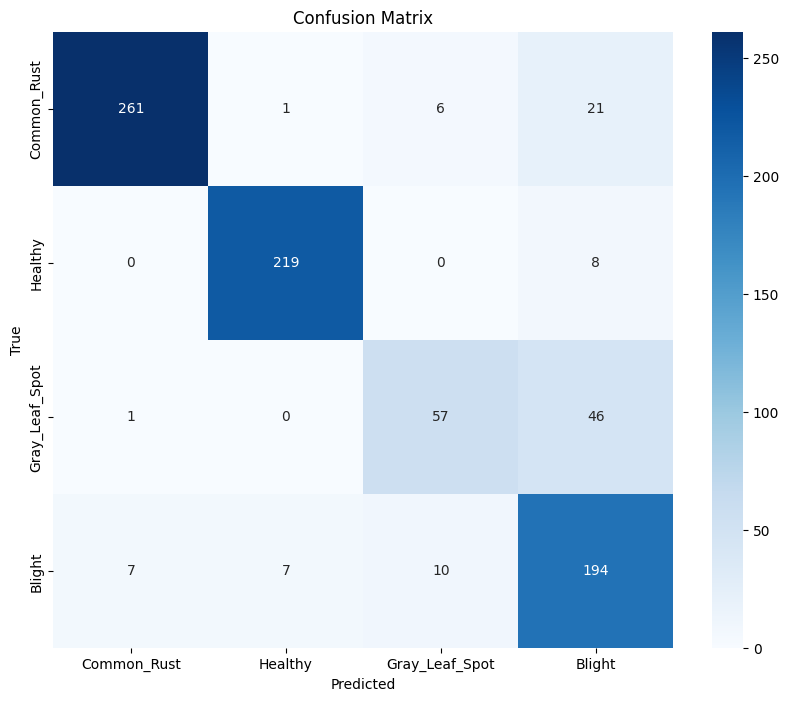


Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.90      0.94       289
           1       0.96      0.96      0.96       227
           2       0.78      0.55      0.64       104
           3       0.72      0.89      0.80       218

    accuracy                           0.87       838
   macro avg       0.86      0.83      0.84       838
weighted avg       0.88      0.87      0.87       838



In [7]:
# Evaluate the model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Confusion matrix and classification report
conf_matrix = confusion_matrix(all_labels, all_preds)
class_names = [str(cls) for cls in le.classes_]
class_report = classification_report(all_labels, all_preds, target_names=class_names)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight'], yticklabels=['Common_Rust', 'Healthy', 'Gray_Leaf_Spot', 'Blight'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:")
print(class_report)